# VAE for bars

In [44]:
from AEML import AEML
from VAEBase import VAEBase
import torch
from torch import nn
import BarDatastream as data
from torch.utils.data import DataLoader

`VAENormal` is a base class of all our variational autoencoders. Write your code between the two pairs of `YOUR CODE HERE` comments.

- `VAENormal.forward()` receives an input image `x`, `enc_...()`odes it, etc., and returns the result of `self.dec()`. Note that, as always, you don't have to worry about gradient computations; PyTorch's autograd feature will take care of it wherever you use the appropriate `torch` data types, methods, and operators.
- `BernoulliLoss.__call__()` returns the scalar loss (the negative ELBO $-L(\mathbf{x})$) associated with the reconstructed Bernoulli parameter array `xz` and the input image `x`.

Both methods actually receive a *batch* of images in the form of a `torch.Tensor` whose first dimension runs over the instances. Except for the computation of the scalar end result of the loss function, your code should hardly have to care; it should mostly read like it receives individual images.

The same solution should work for all exercises.

In [45]:
class VAENormal(VAEBase):
    def __init__(self, enc_mu, enc_logsigma, dec):
        super(VAENormal, self).__init__()
        self.distrib_pz = torch.distributions.Normal(0, 1) # q(z|x), p(z)
        self.enc_mu = enc_mu
        self.enc_logsigma = enc_logsigma
        self.dec = dec

    def forward(self, x):
        x = nn.Flatten()(x)
        ### BEGIN YOUR CODE HERE
        # first, we need to run the encoder to get (mu, logsigma) = enc(x)
        self.mu = self.enc_mu(x)
        self.logsigma = self.enc_logsigma(x)
        self.sigma = torch.exp(self.logsigma)

        # second, we need to sample z from q(z|x) by applying the reparameterization trick as on slide 31
        epsilon = torch.randn_like(self.mu)
        z = self.mu + self.sigma * epsilon

        # third, we need to run the decoder to get xz = dec(z)
        return self.dec(z)
        ### END YOUR CODE HERE

    def encode_mu(self, x):
        return self.enc_mu(nn.Flatten()(x))


class BernoulliLoss: # p(x|z) is Bernoulli; q(z|x) and p(z) are Normal
    def __init__(self, vae, kl_dampfac = 1):
        self.vae = vae
        self.BCE = nn.BCELoss(reduction='none')
        self.kl_dampfac = kl_dampfac

    def __call__(self, xz, x):
        ### BEGIN YOUR CODE HERE
        x = nn.Flatten()(x)

        # we need to maximize the ELBO, which is equivalent to minimizing the negative ELBO: -ELBO = KL - E_q[log p(x|z)]
        # and since we sampled z from q(z|x) we only need to compute: KL - log p(x|z)

        # since p(z) = N(0,1) we can simply use the closed form solution for the KL divergence from slide 32
        sigma_squared = torch.exp(2 * self.vae.logsigma) # since exp(2 * log(sigma)) = exp(log(sigma**2)) = sigma**2
        log_sigma_squared = 2 * self.vae.logsigma # since 2 * log(sigma) = log(sigma**2)
        kl_div_per_image = 1/2 * torch.sum(self.vae.mu**2 + sigma_squared - log_sigma_squared - 1, dim=1)
        # since we are working with a batch of images, we need to somehow combine the kl_div per image to one scalar per batch
        kl_div_per_batch = torch.mean(kl_div_per_image) # taking mean good idea?
        
        # now we need to compute the reconstruction loss: -log p(x|z)
        # according to https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html the BCELoss
        # is already the negative log likelihood
        loss_per_image = torch.sum(self.BCE(xz, x), dim=1)
        # again since we are working with a batch of images, we need to combine the loss per image to one scalar per batch
        loss_per_batch = torch.mean(loss_per_image) # taking mean good idea?

        return self.kl_dampfac * kl_div_per_batch + loss_per_batch
        ### END YOUR CODE HERE

Choose the dimensionality `zdim` of $z$.  **Try 1 and 2 dimensions** and **2 and 4 bars**.

By uncommenting the `model.load()` line you can load a previously-saved model instead of retraining one.

In [46]:
zdim = 2       # number of variates of p(z)
nbars = 4      # number of classes: 2 -> horizontal/vertical; 4 ->hor/ver/diagonal
imgsize = 3    # width and height of the square image

class VAE(VAENormal):
    def __init__(self):
        super(VAE, self).__init__(
            # encoder: x → Normal parameters of q(z|x):
            enc_mu       = nn.Linear(imgsize * imgsize, zdim),
            enc_logsigma = nn.Linear(imgsize * imgsize, zdim),
            # decoder: z → Bernoulli parameter of p(x|z):
            dec = nn.Sequential(nn.Linear(zdim, imgsize * imgsize), nn.Sigmoid())
        )
        
model = VAE()

# model.load('VAE-Bar')
kl_dampfac = 0.1
lossfct = BernoulliLoss(model, kl_dampfac)
ml = AEML(DataLoader(data.BarDatastream(imgsize, nbars, 1024),
                     batch_size = 16, num_workers=6), # changed from 8 -> 6 because I only have 6 cores
          model, lossfct, torch.optim.Adam(model.parameters(), lr=1e-3))

Train your model by running the following cell. Each time it will continue where it left off. So, run it multiple times until the `test_loss` ceases to decrease.

In [ ]:
id = 13
epochs = 100
runs = 1
ml.run(epochs)
model.save(f'models/VAE-Bar_{id}-id_{epochs*runs}-epochs_{zdim}-zdim_{nbars}-nbars_{kl_dampfac}-kl-dampfac_{ml.test():.3f}-test-loss')

In [47]:
def get_model(id, epochs, zdim, nbars, kl_dampfac, test_loss):
    model_path = f'./models/VAE-Bar_{id}-id_{epochs}-epochs_{zdim}-zdim_{nbars}-nbars_{kl_dampfac}-kl-dampfac_{test_loss:.3f}-test-loss'
    print(f"Loading model from {model_path}")
    model.load(model_path)
    return model

Run the below cell after (and optionally between) the training runs and observe how the encoder and decoder are doing.

Loading model from ./models/VAE-Bar_4-id_300-epochs_2-zdim_4-nbars_0.01-kl-dampfac_0.052-test-loss


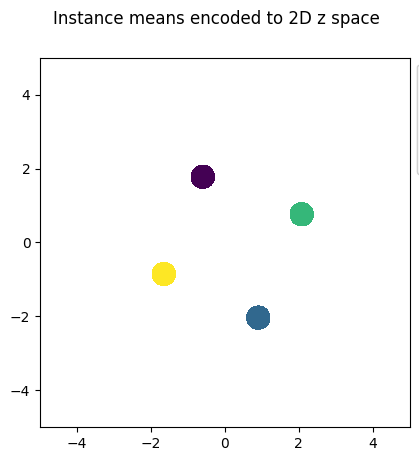

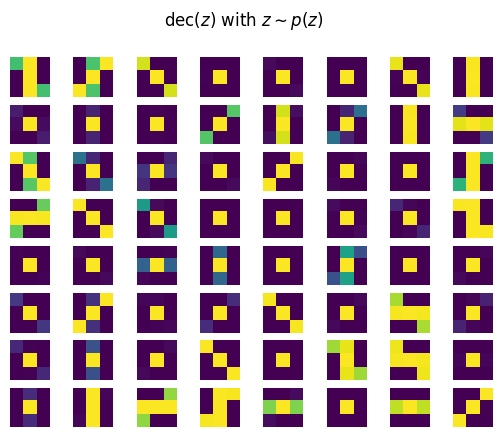

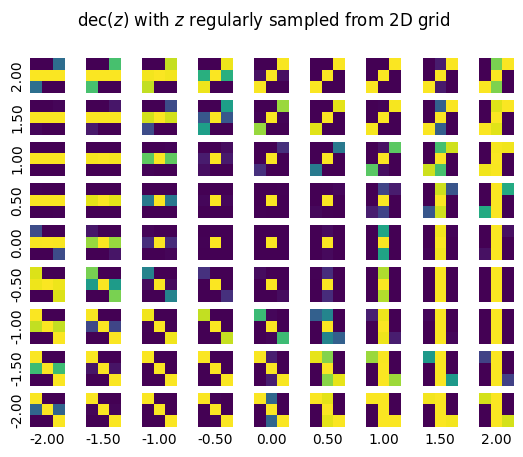

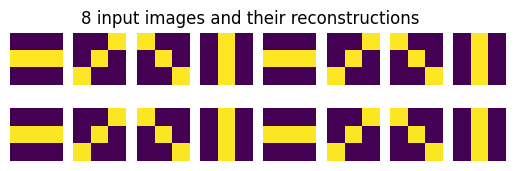

In [48]:
model = get_model(id=4, epochs=300, zdim=zdim, nbars=nbars, kl_dampfac=0.01, test_loss=0.052)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

Submit your best solution (including outputs) with `nbars` = 4. In addition, briefly discuss any observations in the below cell:
- Do you get a good result every time, or are results quantitatively and qualitatively different between runs? If the latter, what are the qualitative differences?
- What happens if you try to learn `nbars` = 4 with `zdim` = 1?

## My observations

### General observations
As we can see in the final training results above, I managed to achieve a test_loss of 0.052 using a damping factor of 0.01 for the KL divergence term of the loss function. Initially, I implemented the loss function without any damping, but the test_loss consistently stagnated between 2.5 and 2.7 across multiple training runs (e.g. 300 epochs). Moreover, the reconstructions of the 8 input images were not particularly good. Consequently, I began experimenting and eventually applied damping to the KL divergence term. This led to a significant improvement in both test_loss and reconstruction quality. It appears that the model was overly constrained by the requirement to keep the latent space close to the prior distribution. By damping the KL divergence term, we allow the model to concentrate more on reconstruction. However, it is important to note that excessive damping could cause the VAE to behave increasingly like a classical AE. If the KL divergence is damped too much, the model will likely lose its ability to generate images from unseen data.

In the following, I loaded the results of a model trained with a damping factor of 0. This transforms the VAE into a classical AE. Comparing the earlier results (damping = 0.01) with the ones below (damping = 0), we observe the following:
- The AE fails to encode the image dataset into the 2D latent space, which is expected. In contrast, the VAE achieves significantly better latent representations.
- As shown in the decoding results, where z is sampled randomly from the prior, the AE fails to generate diagonal images and generates images with crosses. This is not case for the VAE, where the image generation seems to be more diverse but still kind of matches the original dataset distribution.
- Regarding reconstruction, both models achieve nearly perfect results.

These observations suggest that using a damping factor of 0.01 retains enough of the variational aspect while significantly improving reconstruction quality compared to a VAE without damping.

Loading model from ./models/VAE-Bar_5-id_200-epochs_2-zdim_4-nbars_0-kl-dampfac_0.005-test-loss


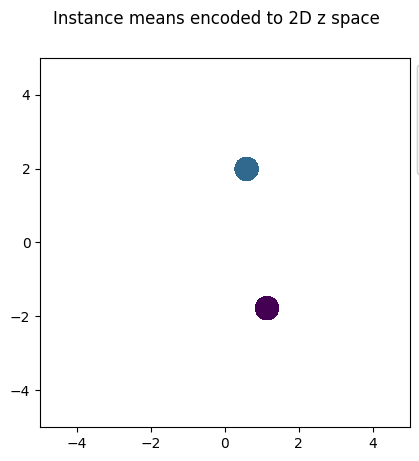

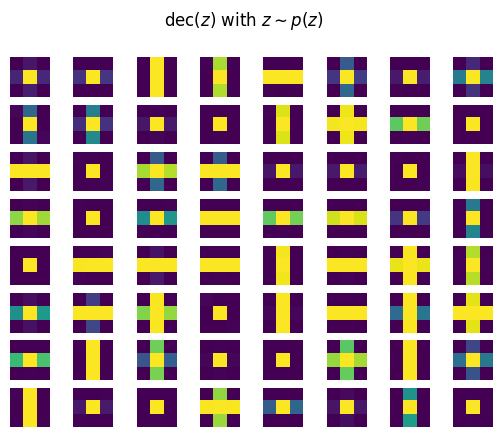

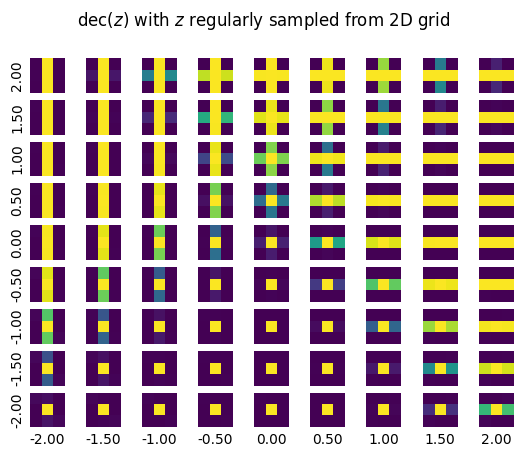

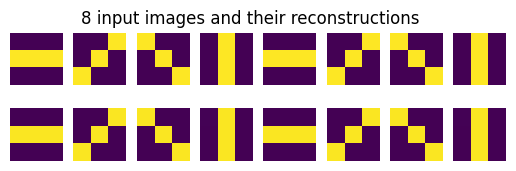

In [ ]:
model = get_model(id=5, epochs=200, zdim=zdim, nbars=nbars, kl_dampfac=0, test_loss=0.005)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

#### Do you get a good result every time, or are results quantitatively and qualitatively different between runs? If the latter, what are the qualitative differences?

Here, I am not sure what you mean by "between runs". This could mean either of the following:
1) Between different training runs of different models (e.g. 100 epochs of one model initialization vs. 100 epochs of another model initialization)
2) Between different training runs of the same model (e.g. 100 epochs -> 200 epochs -> 300 epochs)
3) Between different evaluations of the same model (e.g. 300 epochs vs. 300 epochs vs. 300 epochs)

-> Therefore, I will try to answer all three cases in the following:

1) Differences between different training runs of different models:

    The following two evaluations below show the results of the first training runs for two separately initialized models. As we can see, they differ slightly. The first model produced a somewhat unusual dataset encoding to 2D z-space (which also disappears with more training epochs), but in terms of loss and reconstruction quality, both models perform very similarly. This variation can be attributed to randomness in model parameter initialization and nothing more.

Loading model from ./models/VAE-Bar_1-id_100-epochs_2-zdim_4-nbars_1-kl-dampfac_3.297-test-loss


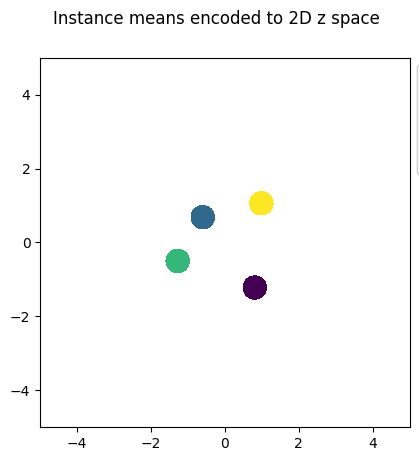

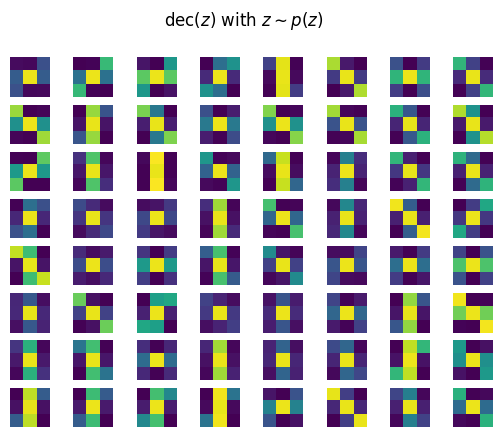

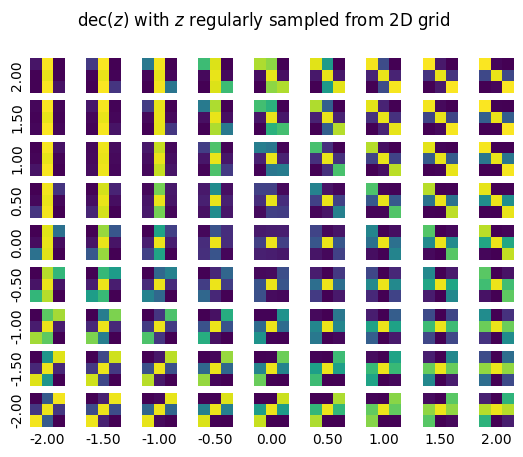

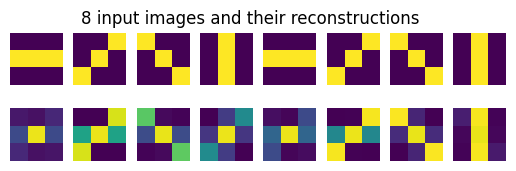

In [ ]:
model = get_model(id=1, epochs=100, zdim=zdim, nbars=nbars, kl_dampfac=1, test_loss=3.297)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

Loading model from ./models/VAE-Bar_2-id_100-epochs_2-zdim_4-nbars_1-kl-dampfac_3.087-test-loss


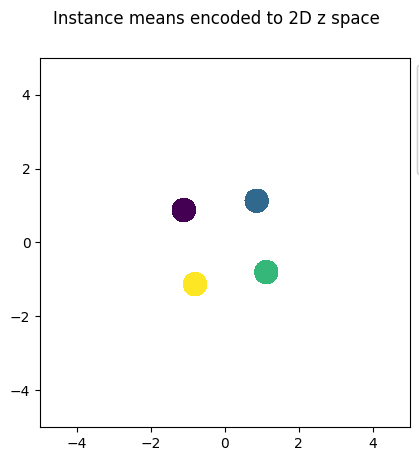

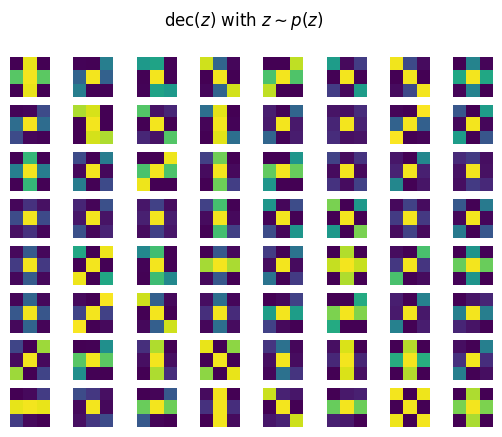

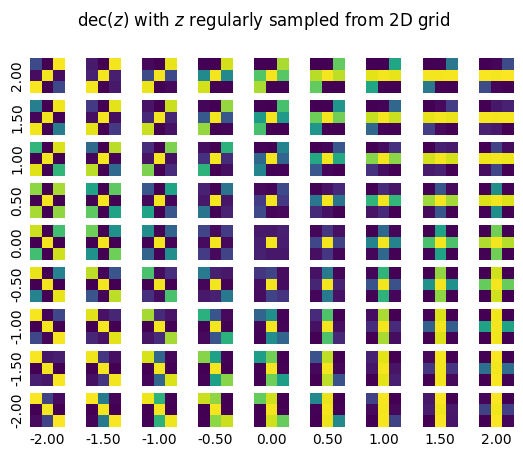

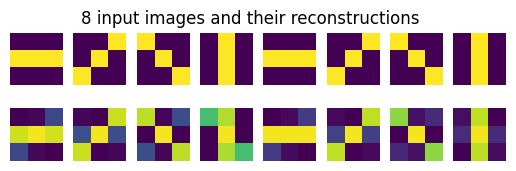

In [ ]:
model = get_model(id=2, epochs=100, zdim=zdim, nbars=nbars, kl_dampfac=1, test_loss=3.087)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

2) Differences between different training runs of the same model:

    The following three evaluations below show the results of three incremental training runs for the same model. In fact, here I loaded the same model which I also loaded first in the previous case above. As already mentioned, the unusual dataset encoding to 2D z-space disappears once the model is trained for 200 and 300 epochs. Overall, we observe significant improvement between 100 and 200 epochs, with the test_loss decreasing from 3.297 to 2.779. Between 200 and 300 epochs, the model no longer improves noticeably and appears to have reached a (local) maximum.
    
    In this case, I used the model trained without damping (damping = 1). As shown, the reconstructions are not bad but also not great. Also the image generation plots exhibit greater variance compared to a model with damping.

Loading model from ./models/VAE-Bar_1-id_100-epochs_2-zdim_4-nbars_1-kl-dampfac_3.297-test-loss


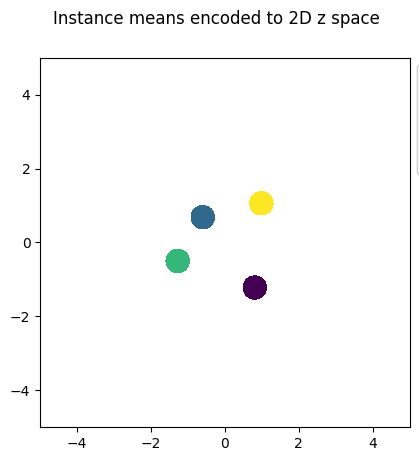

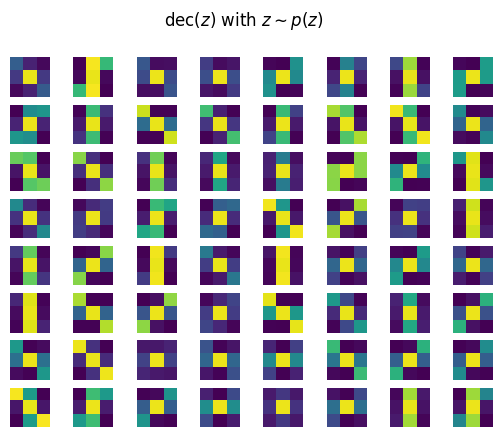

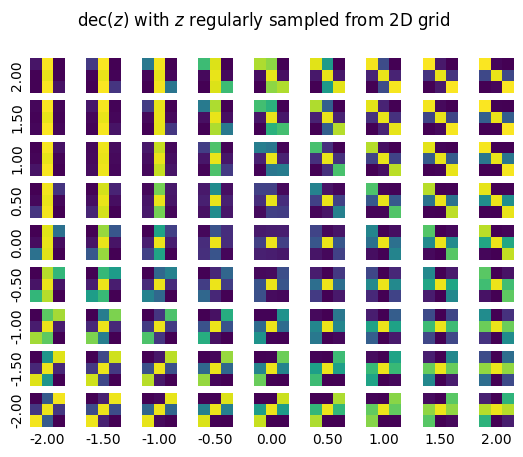

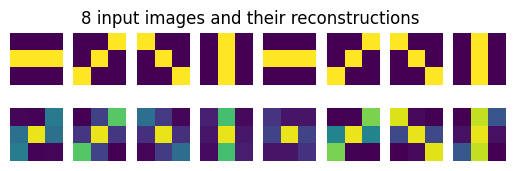

In [49]:
model = get_model(id=1, epochs=100, zdim=zdim, nbars=nbars, kl_dampfac=1, test_loss=3.297)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

Loading model from ./models/VAE-Bar_1-id_200-epochs_2-zdim_4-nbars_1-kl-dampfac_2.779-test-loss


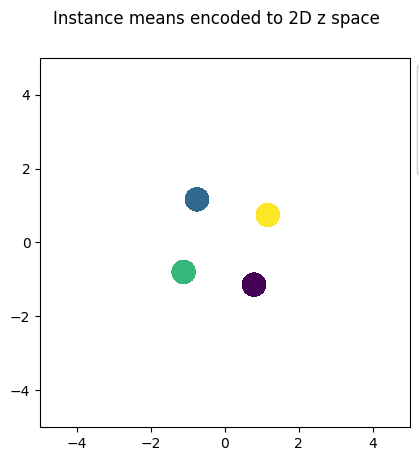

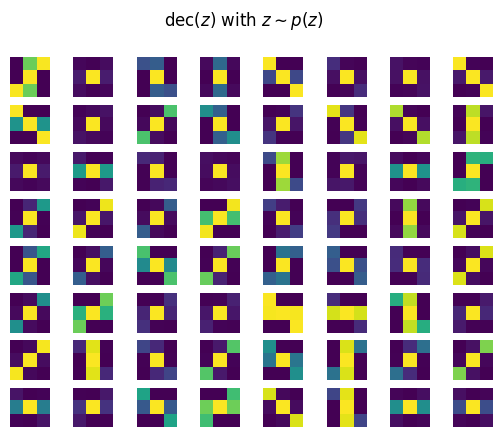

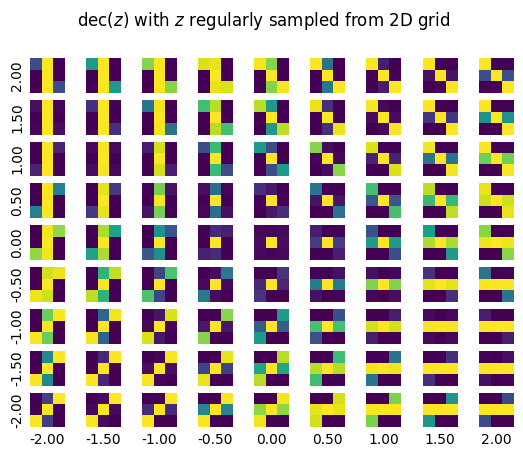

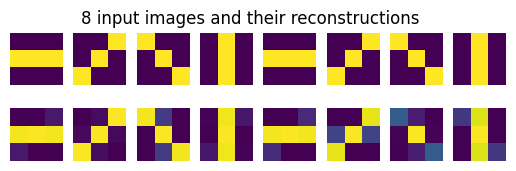

In [ ]:
model = get_model(id=1, epochs=200, zdim=zdim, nbars=nbars, kl_dampfac=1, test_loss=2.779)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

Loading model from ./models/VAE-Bar_1-id_300-epochs_2-zdim_4-nbars_1-kl-dampfac_2.747-test-loss


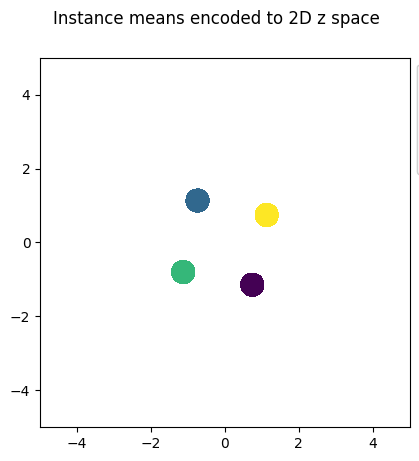

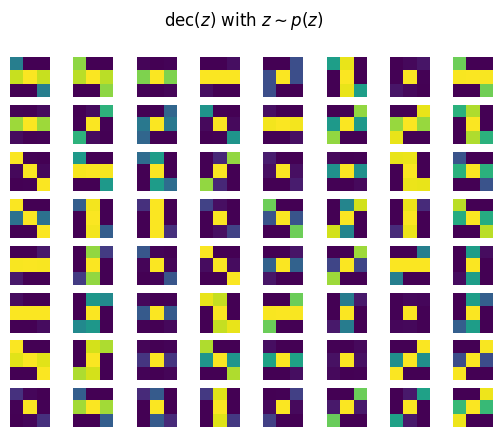

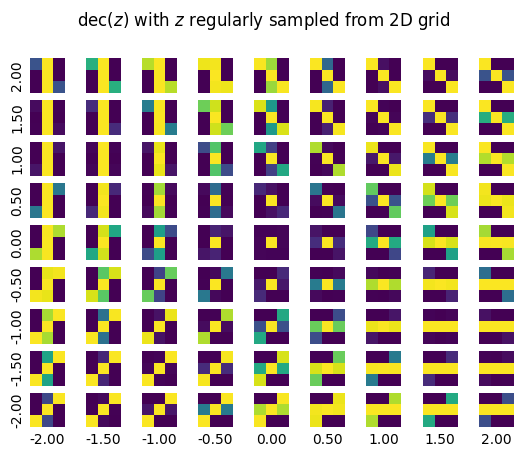

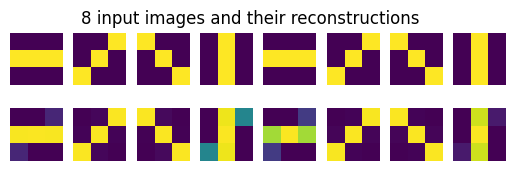

In [ ]:
model = get_model(id=1, epochs=300, zdim=zdim, nbars=nbars, kl_dampfac=1, test_loss=2.747)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

3) Differences between different evaluations of the same model:

    The following two evaluations below show the results of multiple evaluations of the same model. The first and third plots do not differ because they both involve no randomness. The first function just encodes the entire dataset to z-space and plots the mean values. This is obviously deterministic over multiple runs. The third plot decodes always the same z values, which is also deterministic. Therefore, only the second and fourth plots differ between runs. The second plot decodes always newly sampled z values from the prior and the fourth plot always decodes a randomly selected subsample of the image dataset. In general, from the second and fourth plots, we see, that evaluations for different input parameters (z-values or images) yield different results.

    

Loading model from ./models/VAE-Bar_3-id_200-epochs_2-zdim_4-nbars_0.1-kl-dampfac_0.423-test-loss


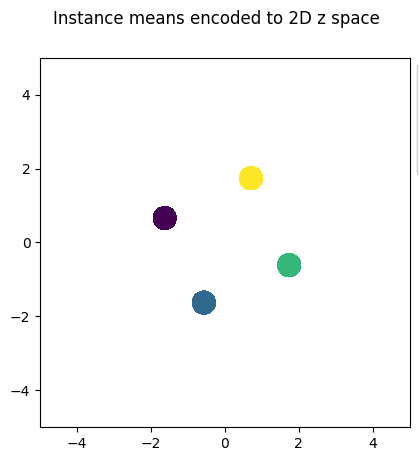

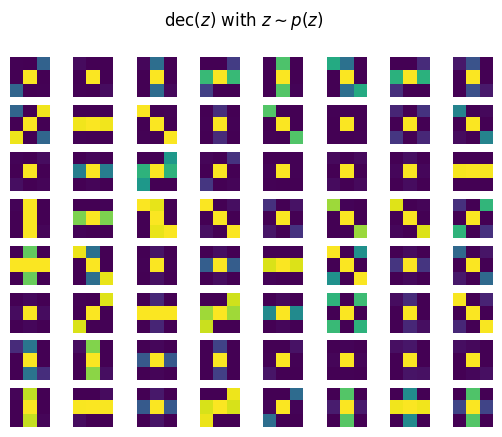

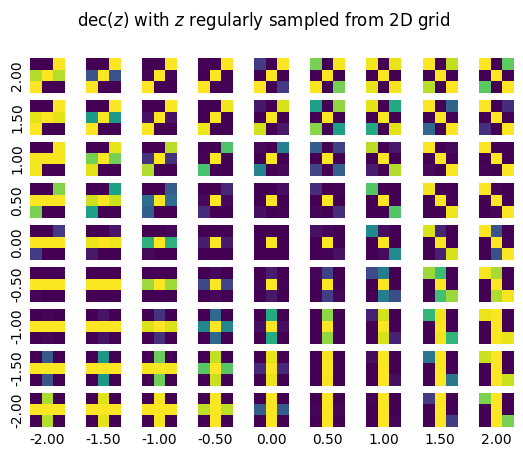

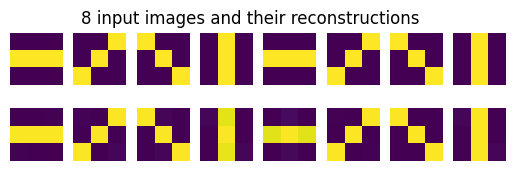

In [ ]:
model = get_model(id=3, epochs=200, zdim=zdim, nbars=nbars, kl_dampfac=0.1, test_loss=0.423)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

Loading model from ./models/VAE-Bar_3-id_200-epochs_2-zdim_4-nbars_0.1-kl-dampfac_0.423-test-loss


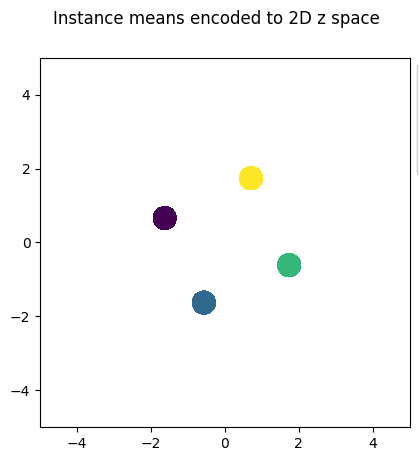

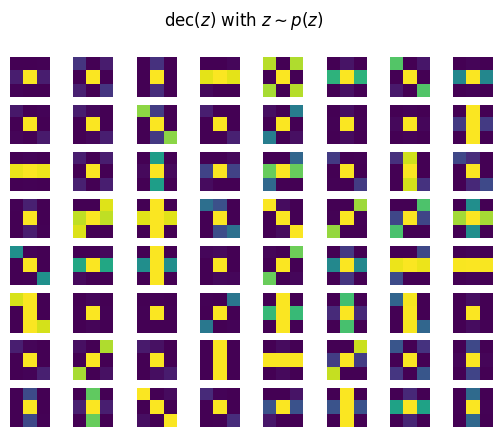

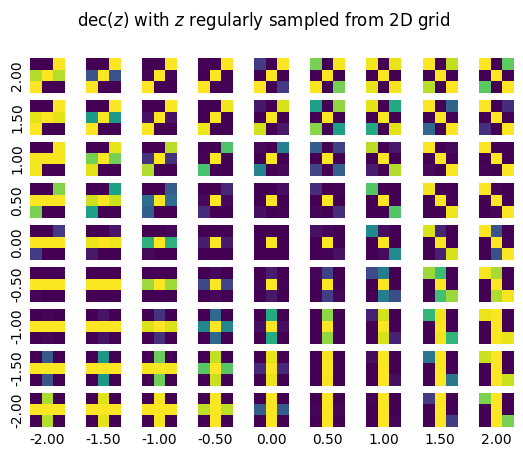

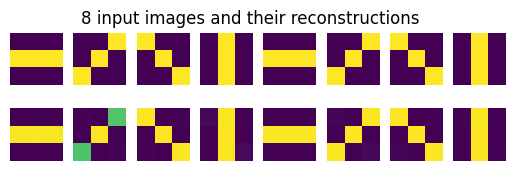

In [ ]:
model = get_model(id=3, epochs=200, zdim=zdim, nbars=nbars, kl_dampfac=0.1, test_loss=0.423)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()

#### What happens if you try to learn `nbars` = 4 with `zdim` = 1?

The following evaluation below shows the results of a model trained with `nbars` = 4 and `zdim` = 1. As we can see, the results are not very good. The test_loss for 200 epochs with dampening factor of 0.01 is 2.245. The model completely fails to reconstruct horizontal bars, struggles with diagonal bars and only manages to reconstruct vertical bars with near perfect accuracy. Additionally, for image generation from unseen data, the model appears capable of generating only diagonal bars. These results also make sense, since we try to encode 2D images to a 1D latent space and vice versa. The number of possible combinations of different images seems to be too large to be adequately captured by a 1D latent space with the current configuration.

In [42]:
zdim = 1       # number of variates of p(z)
nbars = 4      # number of classes: 2 -> horizontal/vertical; 4 ->hor/ver/diagonal
imgsize = 3    # width and height of the square image

class VAE(VAENormal):
    def __init__(self):
        super(VAE, self).__init__(
            # encoder: x → Normal parameters of q(z|x):
            enc_mu       = nn.Linear(imgsize * imgsize, zdim),
            enc_logsigma = nn.Linear(imgsize * imgsize, zdim),
            # decoder: z → Bernoulli parameter of p(x|z):
            dec = nn.Sequential(nn.Linear(zdim, imgsize * imgsize), nn.Sigmoid())
        )
        
model = VAE()

# model.load('VAE-Bar')
kl_dampfac = 0.01
lossfct = BernoulliLoss(model, kl_dampfac)
ml = AEML(DataLoader(data.BarDatastream(imgsize, nbars, 1024),
                     batch_size = 16, num_workers=6), # changed from 8 -> 6 because I only have 6 cores
          model, lossfct, torch.optim.Adam(model.parameters(), lr=1e-3))

Loading model from ./models/VAE-Bar_8-id_200-epochs_1-zdim_4-nbars_0.01-kl-dampfac_2.245-test-loss


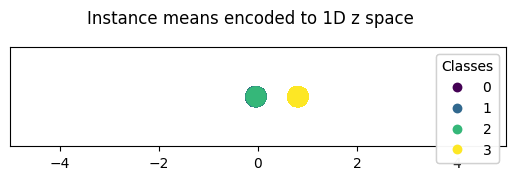

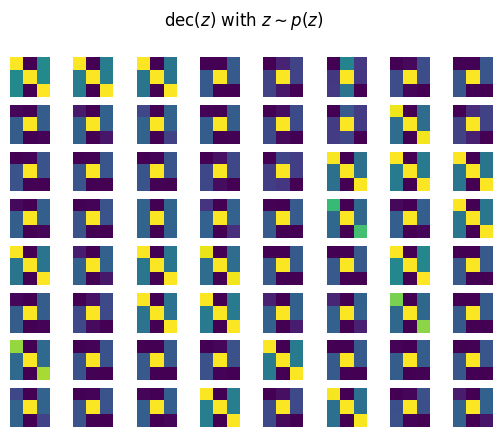

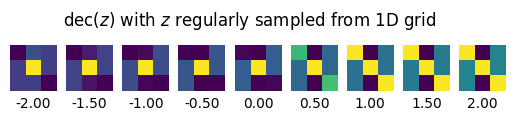

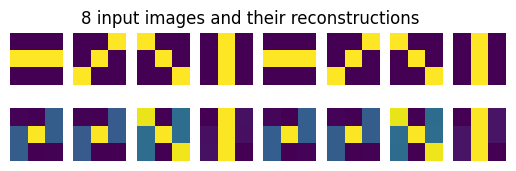

In [43]:
model = get_model(id=8, epochs=200, zdim=zdim, nbars=nbars, kl_dampfac=0.01, test_loss=2.245)
ml.plotEncDataset()
model.plotDecRandom(zdim)
model.plotDecGrid(zdim)
ml.plotReconDataset()